In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

In [3]:
# Reading the data
df = pd.read_csv("trial1.csv")
df.head(5)

,Time/sec,Potential/V,Current/A,Charge/C,Capacity/Ah,Nominal_Capacity/Ah
0,0.4,3.54,1.25,0.00,0.0,2.5
1,1.0,3.54,1.25,0.95,0.0,2.5
2,2.0,3.54,1.25,2.28,0.0,2.5
3,3.0,3.55,1.25,3.46,0.0,2.5
4,4.0,3.55,1.25,4.64,0.0,2.5


In [4]:
df.rename(columns= {'Time/sec':'Time', 'Potential/V':'Potential', 'Current/A':'Current', 'Charge/C':'Charge',
                    'Capacity/Ah':'Capacity', 'Nominal_Capacity/Ah':'Nominal_Capacity'},inplace=True)

In [5]:
df.insert(loc = 6,column ='Energy',value=df['Capacity']*df["Potential"])

In [6]:
df.insert(loc = 7,column ='Power',value=df['Current']*df["Potential"])

In [7]:
df.insert(loc = 8,column ='SOC',value=df['Capacity']/df['Nominal_Capacity']) 

In [8]:
df.head()

,Time,Potential,Current,Charge,Capacity,Nominal_Capacity,Energy,Power,SOC
0,0.4,3.54,1.25,0.00,0.0,2.5,0.0,4.4250,0.0
1,1.0,3.54,1.25,0.95,0.0,2.5,0.0,4.4250,0.0
2,2.0,3.54,1.25,2.28,0.0,2.5,0.0,4.4250,0.0
3,3.0,3.55,1.25,3.46,0.0,2.5,0.0,4.4375,0.0
4,4.0,3.55,1.25,4.64,0.0,2.5,0.0,4.4375,0.0


In [9]:
df.describe()

,Time,Potential,Current,Charge,Capacity,Nominal_Capacity,Energy,Power,SOC
count,242885.000000,242885.000000,242885.000000,242885.000000,242885.000000,242885.0,242885.000000,242885.000000,242885.000000
mean,124950.840426,3.839404,0.034547,5083.012369,1.412284,2.5,5.702908,0.394564,0.564913
std,72231.050997,0.385144,1.234725,3185.178306,0.884470,0.0,3.763641,4.354979,0.353788
min,0.400000,2.750000,-2.500000,0.000000,0.000000,2.5,0.000000,-9.650000,0.000000
25%,62490.800000,3.440000,0.000000,1920.000000,0.530000,2.5,1.895000,0.000000,0.212000
50%,124983.000000,3.940000,0.080000,5790.000000,1.610000,2.5,6.181200,0.336000,0.644000
75%,187475.100000,4.200000,1.250000,8280.000000,2.300000,2.5,9.660000,4.662500,0.920000
max,249967.200000,4.200000,1.260000,8680.000000,2.410000,2.5,10.122000,5.292000,0.964000


In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

numericals = ['Time','Potential','Current','Charge','Capacity','Nominal_Capacity','Energy','Power'] # Not Normalizing the Y(target Variable) - which is SOC
df[numericals] = scaler.fit_transform(df[numericals])

In [11]:
df.describe()

,Time,Potential,Current,Charge,Capacity,Nominal_Capacity,Energy,Power,SOC
count,242885.000000,242885.000000,242885.000000,242885.000000,242885.000000,242885.0,242885.000000,242885.000000,242885.000000
mean,0.499868,0.751313,0.674082,0.585601,0.586010,0.0,0.563417,0.672237,0.564913
std,0.288963,0.265617,0.328384,0.366956,0.367000,0.0,0.371828,0.291459,0.353788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.249995,0.475862,0.664894,0.221198,0.219917,0.0,0.187216,0.645831,0.212000
50%,0.499997,0.820690,0.686170,0.667051,0.668050,0.0,0.610670,0.668317,0.644000
75%,0.749998,1.000000,0.997340,0.953917,0.954357,0.0,0.954357,0.957870,0.920000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.964000


In [12]:
def plot_his(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [13]:
Y = df.pop('SOC')
X = df

In [14]:
x = X[0:10000]

In [15]:
y = Y[0:10000]

In [16]:
x.shape, y.shape

((10000, 8), (10000,))

In [17]:
x_test = X[11000:21000]
y_test = Y[11000:21000]

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
clf = GaussianProcessRegressor(random_state=42)


In [19]:
clf.fit(x,y)

GaussianProcessRegressor(random_state=42)

In [21]:
y_pred_one = clf.predict(x_test)

In [22]:
y_pred_one.shape

(10000,)

In [24]:
# plt.figure(figsize=(14,8))
# plt.scatter(y_test, y_test, color='blue')
# plt.scatter(y_pred_one, y_pred_one, color='red')
# plt.show()

In [25]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [26]:
score = rmsle(y,y_pred_one)
print(score)

0.48154401349227793


In [27]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

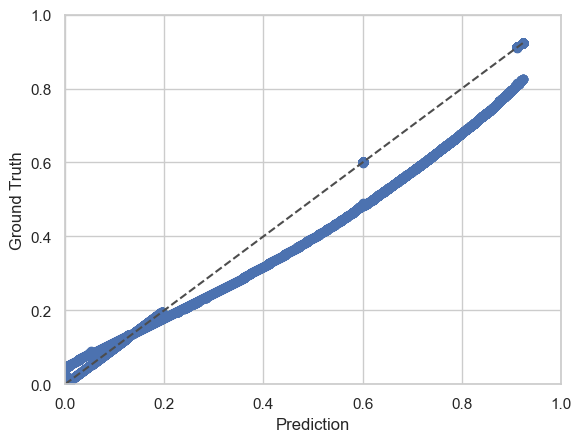

In [32]:
plt.scatter(y_test,y_pred_one)
plt.plot([min(y_pred_one),max(y_pred_one)], [min(y_pred_one),max(y_pred_one)], ls="--", c=".3")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.show()

InvalidIndexError: (slice(None, None, None), slice(None, None, None))

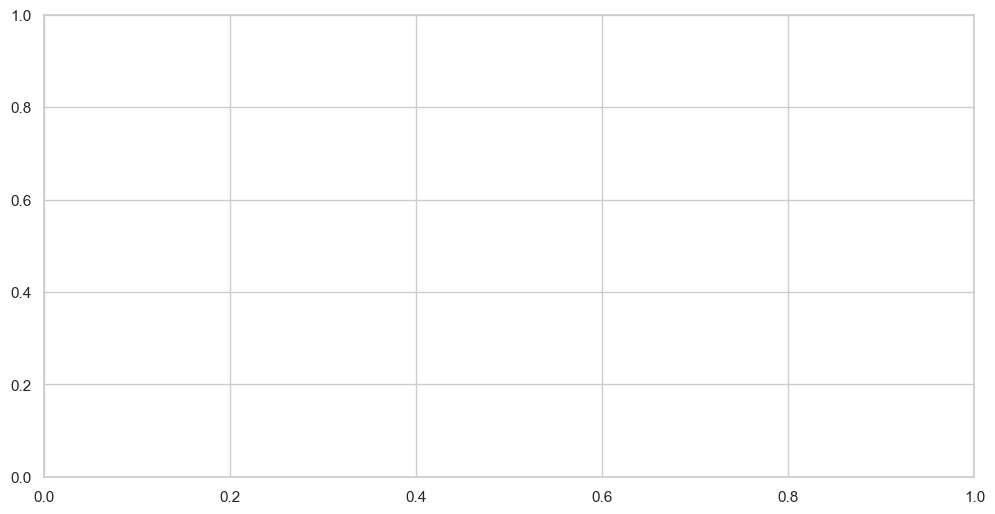

In [49]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(x_test[:,:], y, marker='o', color='black', linewidth=0)
plt.plot(x_test[:,:], y_pred_one, marker='x', color='steelblue')
plt.suptitle("$GaussianProcessRegressor(kernel=RBF)$ [default]", fontsize=20)
plt.axis('off')